## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [157]:
# Import some useful libraies
import numpy as np
import sys
# np.set_printoptions(threshold=sys.maxsize)
from scipy import ndimage
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# %matplotlib qt // qt is not invoking properly, use inline instead
%matplotlib inline


(20,)


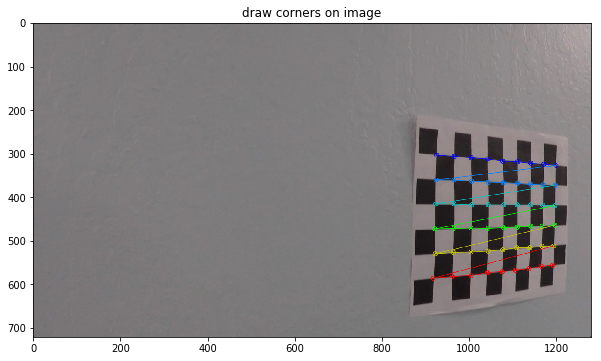

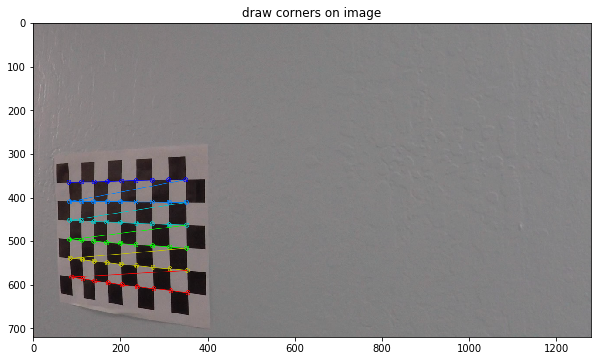

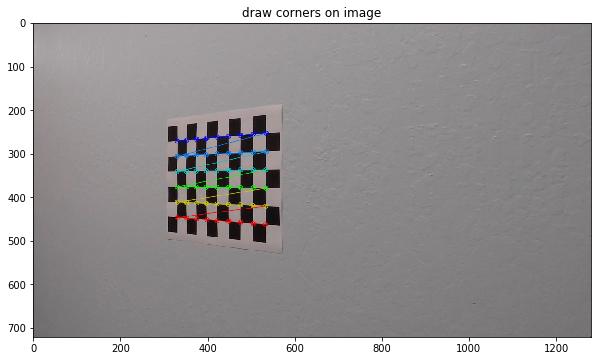

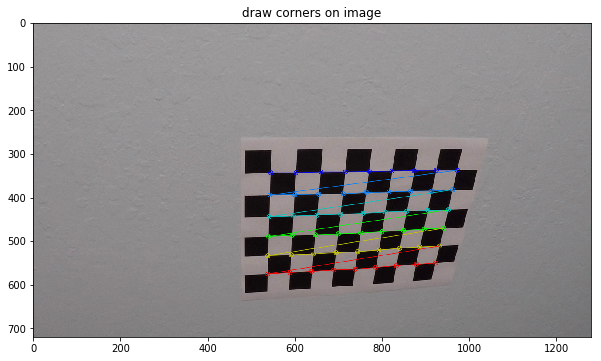

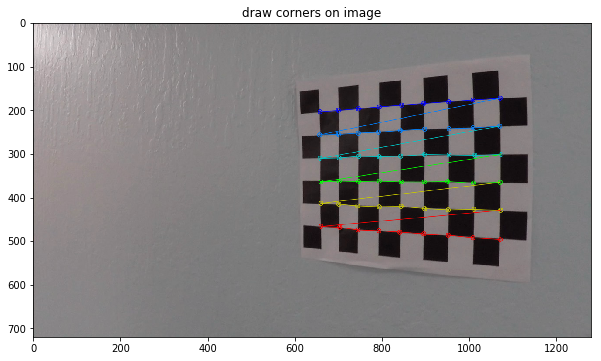

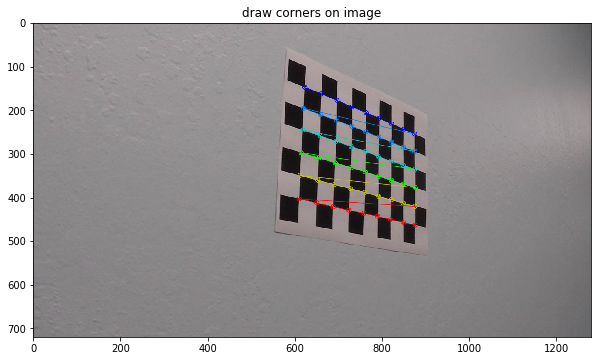

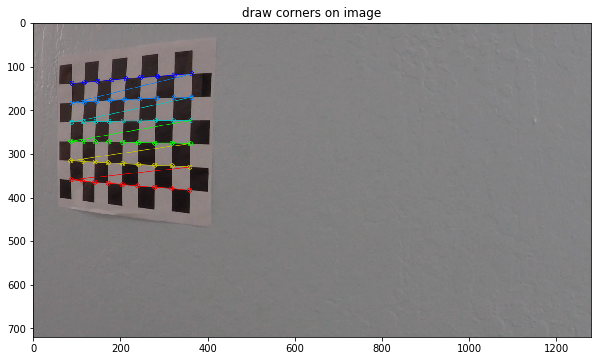

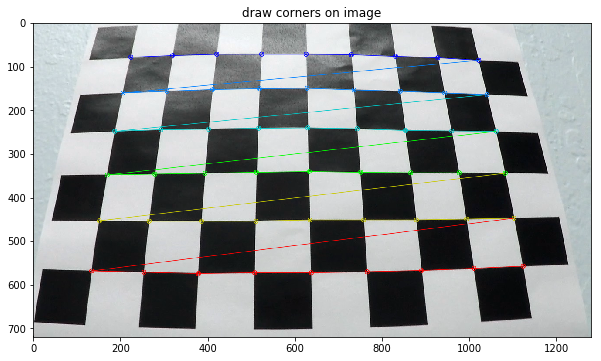

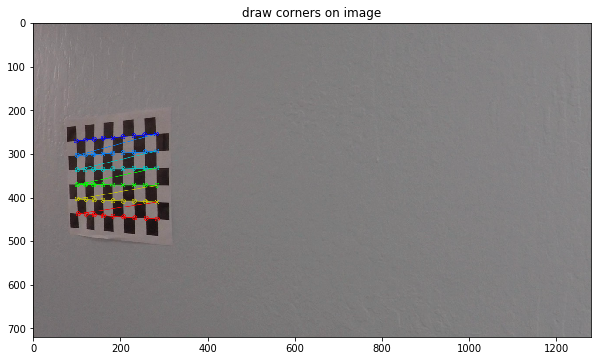

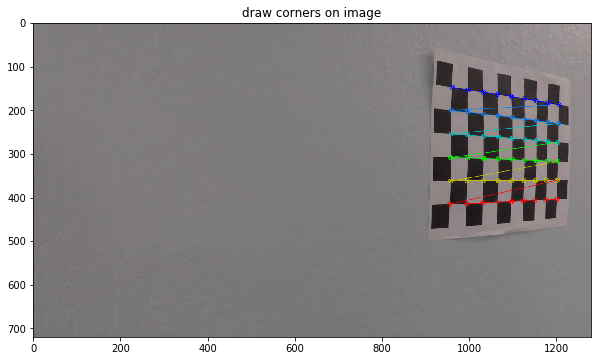

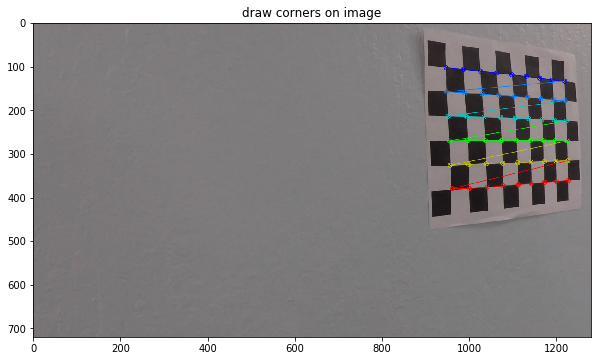

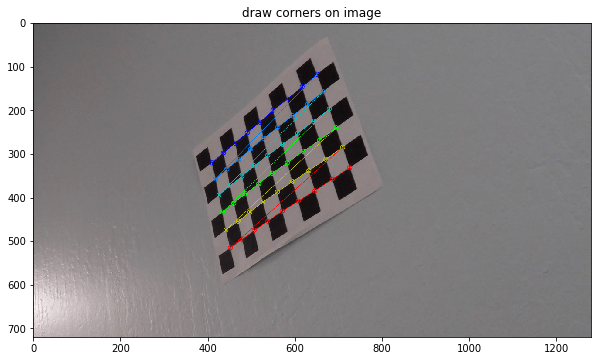

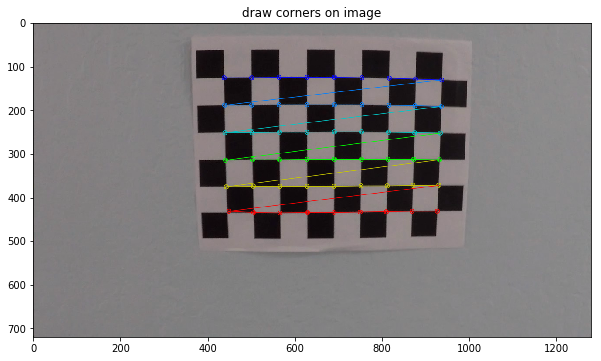

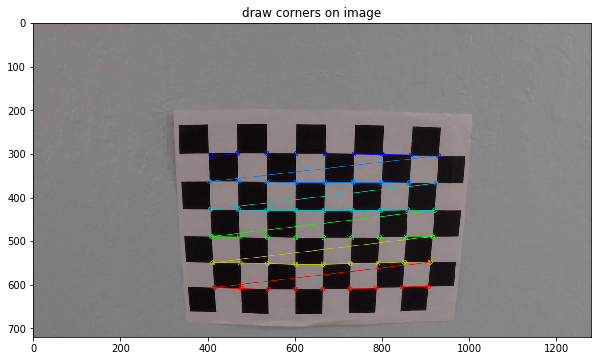

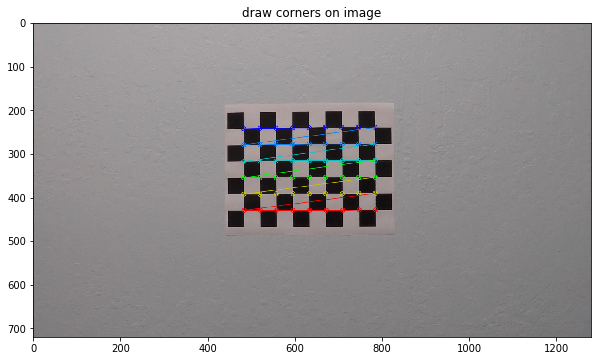

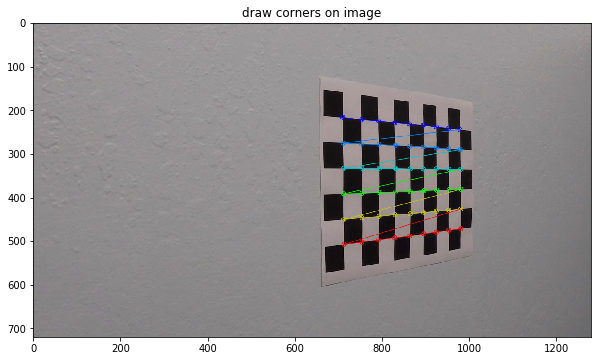

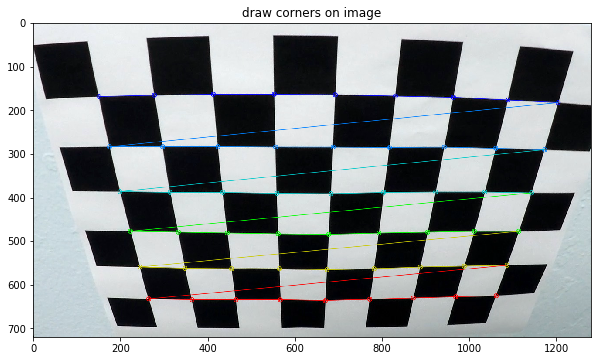

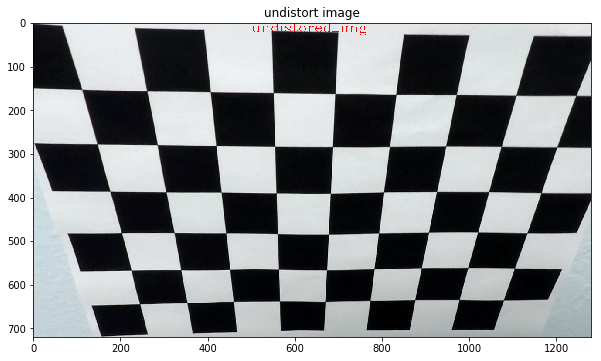

In [158]:
# function to calibrate camera
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print(np.array(images).shape)
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            fig1 = plt.figure(figsize=(10,7))
            fig1.add_subplot(1,1,1)
            plt.imshow(img)
            plt.title("draw corners on image")
#     Camera calibration, given object points, image points, and the shape of the grayscale image
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
#     Test on to undistor an image 
    cv2.putText(img, "original_withCorner", org=(500,20), fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 1, color = (255,0,0))
    
    img_test = cv2.imread('camera_cal/calibration2.jpg')
    undst_test = cv2.undistort(img_test,mtx,dist,None,mtx)
    cv2.putText(undst_test, "undistored_img", org=(500,20), fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 1, color = (255,0,0))
    #     out_put = cv2.imwrite("camera_cal/original_withCorner.jpg",img) 
    #     out_put = cv2.imwrite("camera_cal/undistored_img.jpg",undst_test)
    fig1 = plt.figure(figsize=(10,7))
    fig1.add_subplot(1,1,1)
    plt.imshow(undst_test)
    plt.title("undistort image")
    return mtx,dist
[mtx,dist] = calibrate_camera()

In [159]:
def undistort(img,mtx,dist):
    undst = cv2.undistort(img,mtx,dist,None,mtx)
    return undst

In [160]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # sobel operator need signle channel img
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
#     plt.imshow(scaled_sobel,cmap = 'gray')
    return binary_output

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # sobel operator need signle channel img
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag > mag_thresh[0]) & (gradmag < mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # sobel operator need signle channel img
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def combined_sobel(image, ksize = 3):
# Choose a Sobel kernel size
#     ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 220))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 220))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 220))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     combined[((gradx == 1) & (grady == 1))] = 1
#     combined[ ((mag_binary == 1) & (dir_binary == 1))] = 1
#     plt.imshow(gradx,cmap = 'gray')
    return combined, gradx, grady,mag_binary, dir_binary

In [161]:
def color_space(img,channel='s',thresh=(170,255)):
#     make sure if img is RGB or BGR
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if channel == 's':
        single_channel = hls[:,:,2]
        
    elif channel == 'r': 
        single_channel = rgb[:,:,0]
    
    # Threshold color channel
    binary = np.zeros_like(single_channel)
    binary[(single_channel >= thresh[0]) & (single_channel <= thresh[1])] = 1
    return binary, single_channel 

In [162]:
def calc_perspective_matrix():
# warp the image by doing a perspective transform
# manually define four source point(necessary for affine transform)
# perform perspective transform on some test images
    first_time = False
    img = cv2.imread('test_images/straight_lines1.jpg')
#     img = cv2.imread('test_images/test1.jpg')
    [y,x,z] = img.shape
    img_size = (x,y)
    undst = undistort(img,mtx,dist)
#     print("original img size = ", x,y, "\n", "undistort img size = ",undst.shape,"\n")
    if first_time:
        undst = undistort(img,mtx,dist)
        fig2 = plt.figure(figsize=(10,7))
        fig2.add_subplot(4,1,1)
        plt.imshow(img)
        plt.title("original")
        fig2.add_subplot(4,1,2)
        plt.imshow(undst)
        plt.title("undistorted")
        line_image = np.copy(img)*0 
        cv2.line(line_image,(int(0),int(y*0.9)),(int(x),int(y*0.9)),(0,255,0),2)
        cv2.line(line_image,(int(0),int(y*0.65)),(int(x),int(y*0.65)),(0,255,0),2)
        combine_image = cv2.addWeighted(undst,1,line_image,2,0)
        fig2.add_subplot(4,1,3)
        plt.imshow(combine_image)
        plt.title("manual identify src point")
        picture = cv2.imwrite("test_images/prepare_warp1.jpg",combine_image) 
#         prepare a test image with lines overlay
        test_line = np.copy(img)*0 
        cv2.line(test_line,(318,650),(625,433),(0,255,0),2)
        cv2.line(test_line,(993,650),(656,433),(0,255,0),2)
        combine_test_image = cv2.addWeighted(undst,1,test_line,2,0)
        fig2.add_subplot(4,1,4)
        plt.imshow(combine_test_image)
        plt.title("prepare test image with src point")
        picture = cv2.imwrite("test_images/prepare_test1.jpg",combine_test_image) 
        return None, None
    else:
    #     use manually found src and dst point to calculate Perspect Transform Matrix
        src = np.float32([[301,650],[1005,650],[716,469],[567,469]])
        dst = np.float32([[350,650],[850,650],[850,0],[350,0]])
        M = cv2.getPerspectiveTransform(src,dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        return M, Minv,img_size
[M,Minv,img_size] = calc_perspective_matrix()

In [163]:
def warp(undst,M,img_size):
    warped = cv2.warpPerspective(undst,M,img_size,flags=cv2.INTER_LINEAR)
    return warped

In [164]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # does the line has enough pixel against min_pixel_count to be polyfitted?
        self.enough_pixel = False
        # does the line used avg coeff because either not enough pixel or larger than diff_thresh
        self.used_avg_coeff = False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([False])
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.coeff_diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #pixel count for the line         
        self.pixel_count = None
        #min pixel count         
        self.min_pixel_count = 5
        #calculate pixel count for the line
    def set_pixel_count(self):
        self.pixel_count = len(self.allx)
        if self.pixel_count > self.min_pixel_count:
            self.enough_pixel = True
            self.detected = False
        else :
            self.detected = True

In [165]:
def check_fit_coeff(line,line_avg):
#     check x position where y = 650 
    # define center diff threshold 
    diff_threshold = 1000
    # get line_avg fit coeff
    fit_avg = line.best_fit
    # create line point to calculate difference in x direction    
    ploty = np.linspace(0,719,720)
    line_point = line.current_fit[0]*ploty**2 + line.current_fit[1]*ploty + line.current_fit[2]
#     print("from check_fit_coeff",line_point.shape,fit_avg.shape )
    try:
        fit_avg_point = fit_avg[0]*ploty**2 + fit_avg[1]*ploty + fit_avg[2]
        line_diff = fit_avg_point - line_point
#         line_diff = int(sum(np.abs(line_diff))/720)
        line_diff = int(max(np.abs(line_diff)))
#         print("inside check_fit_coeff,",fit_avg_point.shape,line_point.shape,line_diff )
    except:
        line_diff = -1
#     try:
#         # calculate coeff_diff with nonLinear relationship     
    try:
        coeff_diff = line.coeff_diffs[0] + line.coeff_diffs[1] + line.coeff_diffs[2]
    except:
        coeff_diff = -1
        
    
    # if diff larger than threshold then replace the fitt_coeff with fit_avg,set used_avg_coeff to True
    if line_diff > diff_threshold:
#         line.current_fit = fit_avg
        line.used_avg_coeff = True
    return line_diff,coeff_diff,line

In [166]:
def create_line_point(line_coeff,ploty = np.linspace(0,719,720)):
    line_point = line_coeff[0]*ploty**2+line_coeff[1]*ploty+line_coeff[2]
    return line_point,ploty

In [167]:
def compare_lines(left_line, right_line):
    # define diff threshold 
    diff_threshold = 50
    left_line_point = create_line_point(left_line.current_fit)[0]
    right_line_point = create_line_point(right_line.current_fit)[0]
    width = right_line_point - left_line_point
    center_diff = np.mean(right_line_point) - np.mean(left_line_point)
#     compare pixel_count, considering left solid yellow 
    try:
        factor = left_line.pixel_count/right_line.pixel_count
    except:
        factor = 100
    if factor > 2:
        right_line.current_fit = np.copy(left_line.current_fit)
        right_line.current_fit[2] = right_line.current_fit[2] + center_diff
    elif factor < 0.5:
        left_line.current_fit = np.copy(right_line.current_fit)
        left_line.current_fit[2] = left_line.current_fit[2] - center_diff
        
    return left_line,right_line, factor,center_diff
#     compare x difference and assign one to another

In [168]:
# function to check line pixel
def create_fit_coeff(line,line_avg):
    # define diff threshold 
    diff_threshold = 100
    # define coeff diff threshold 
    diff_coeff_threshold = 0  
    # calculate line_avg fit coeff
    fit_avg = np.zeros_like(line_avg[0].current_fit)
    for i in range(len(line_avg)):
        if sum(line_avg[i].current_fit) > 0:
#             fit_avg is containminated with current_fit !!!
#             if use best_fit to update fit_avg than it will drift away from current_fit    
#             fit_avg = fit_avg + line_avg[i].current_fit
            fit_avg = fit_avg + line_avg[i].current_fit
        else: 
            i = i-1
            break
    # store avg_fit coeff as current line's best fit, which is previous best_fit avg
#     print("from create_fit_coeff", i)
    fit_avg = fit_avg/(i+1)
#     line.best_fit = current_fit|fit_avg
    # if not enough pixel then use avg fit_coeff,set used_avg_coeff to True
    if not line.enough_pixel:
        line.current_fit = fit_avg
        line.best_fit = line.current_fit
        line.used_avg_coeff = True
    else:
        # Fit a second order polynomial to each using `np.polyfit`
        line.current_fit = np.polyfit(line.ally, line.allx, 2)
    
    if i==-1:
        line.best_fit = line.current_fit
        line_diff = -1
        center_diff = -1
    else:
        # create line point to calculate difference in x direction    
        line_point = create_line_point(line.current_fit)[0]
        try:
            fit_avg_point = create_line_point(fit_avg)[0]
            line_diff = fit_avg_point - line_point
    #         line_diff = int(sum(np.abs(line_diff))/720)
            line_diff = int(max(np.abs(line_diff)))
            center_diff = np.mean(line_point) - np.mean(fit_avg_point)
        except:
            line_diff = -1
            center_diff = -1
        line.best_fit = fit_avg
    return line_diff,center_diff,line

In [169]:
def find_lane_pixels(binary_warped,left_line, right_line):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]
    left_line.set_pixel_count()
    right_line.set_pixel_count()
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    return left_line,right_line,out_img


def search_around_poly(binary_warped,left_line_avg,right_line_avg,left_line,right_line):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
#     print("from search_arround_poly", )
    left_lane_inds = ((nonzerox-margin)<(left_line_avg[-1].current_fit[0]*nonzeroy**2+left_line_avg[-1].current_fit[1]*nonzeroy+left_line_avg[-1].current_fit[2]))&((nonzerox+margin)>(left_line_avg[-1].current_fit[0]*nonzeroy**2+left_line_avg[-1].current_fit[1]*nonzeroy+left_line_avg[-1].current_fit[2]))
    right_lane_inds = ((nonzerox-margin)<(right_line_avg[-1].current_fit[0]*nonzeroy**2+right_line_avg[-1].current_fit[1]*nonzeroy+right_line_avg[-1].current_fit[2]))&((nonzerox+margin)>(right_line_avg[-1].current_fit[0]*nonzeroy**2+right_line_avg[-1].current_fit[1]*nonzeroy+right_line_avg[-1].current_fit[2]))
    
    # Again, extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]
    left_line.set_pixel_count()
    right_line.set_pixel_count()
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0,719,720)
    left_fitx = create_line_point(left_line_avg[-1].current_fit)[0]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_fitx = create_line_point(right_line_avg[-1].current_fit)[0]
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return left_line,right_line,result
    


    
    
    
#  function to control finding lane pixel and fitting the lane pixel 
def fit_polynomial(binary_warped):
#     global left_fit_prev
    global left_line_avg
    global right_line_avg
    global left_fitx
    global right_fitx
    global ploty
    left_line = Line()
    right_line = Line()
#     check if we have previous fitting result: 
    if left_line_avg[-1].enough_pixel & right_line_avg[-1].enough_pixel:
        [left_line,right_line,out_img] = search_around_poly(binary_warped,left_line_avg,right_line_avg,left_line,right_line)        
    else:
        [left_line,right_line,out_img] = find_lane_pixels(binary_warped,left_line,right_line)
    if not left_line.enough_pixel or not right_line.enough_pixel:
        [left_line,right_line,out_img] = find_lane_pixels(binary_warped,left_line,right_line)
# logic to deal with no detection or wrong detection to start sliding box again 
# create fit coeff based on pixel detected
    [diff_left,center_diff_left,left_line] = create_fit_coeff(left_line, left_line_avg)
    [diff_right,center_diff_right,right_line] = create_fit_coeff(right_line, right_line_avg)
    [left_line,right_line,factor,center_diff] = compare_lines(left_line,right_line)
# Sanity check against prev frame 
# Prepare check_fit argument
#     [diff_left,diff_coeff_left,left_line] = check_fit_coeff(left_line)
#     [diff_right,diff_coeff_right,right_line] = check_fit_coeff(right_line)
# Calculate curvature in real world dimentions 
    left_line.radius_of_curvature = measure_curvature_real(left_line)
    right_line.radius_of_curvature = measure_curvature_real(right_line)
    
# Fill and Update left_fit_prev and right_fit_prev
# check if left_fit_prev and right_fit_prev not filled
# helper parameter
    matrix_full = True
    for i in range(len(left_line_avg)):
        if not sum(left_line_avg[i].current_fit):
            left_line_avg[i] = left_line
            right_line_avg[i] = right_line
            matrix_full = False
            break
#     shift left_fit_prev and right_fit_prev
    if matrix_full:
        left_line_avg[0:i] = np.copy(left_line_avg[1:i+1])
        right_line_avg[0:i] = np.copy(right_line_avg[1:i+1])
        left_line_avg[i] = left_line
        right_line_avg[i] = right_line

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])    
    
    try:
        left_fitx = create_line_point(left_line.current_fit,ploty)[0]
        right_fitx = create_line_point(right_line.current_fit,ploty)[0]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    try:
        left_best_fitx = create_line_point(left_line.best_fit,ploty)[0]
        right_best_fitx = create_line_point(right_line.best_fit,ploty)[0]
    except:
        print('best_fitx has no value')
        left_best_fitx = 1*ploty
        right_best_fitx = 2*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    # add fit line, and avg_line(best_fit) plot to out_img
    left_pts = np.array([left_fitx,ploty]).T
    left_pts = np.int32(left_pts)
    left_pts = left_pts.reshape((-1,1,2))
    out_img = cv2.polylines(out_img, [left_pts], 
                      isClosed = False, color = (255,255,0), thickness = 2)
    right_pts = np.array([right_fitx,ploty]).T
    right_pts = np.int32(right_pts)
    right_pts = right_pts.reshape((-1,1,2))
    out_img = cv2.polylines(out_img, [right_pts], 
                      isClosed = False, color = (255,255,0), thickness = 2)
    
    left_best_pts = np.array([left_best_fitx,ploty]).T
    left_best_pts = np.int32(left_best_pts)
    left_best_pts = left_best_pts.reshape((-1,1,2))
    out_img = cv2.polylines(out_img, [left_best_pts], 
                      isClosed = False, color = (0,255,255), thickness = 2)
    right_best_pts = np.array([right_best_fitx,ploty]).T
    right_best_pts = np.int32(right_best_pts)
    right_best_pts = right_best_pts.reshape((-1,1,2))
    out_img = cv2.polylines(out_img, [right_best_pts], 
                      isClosed = False, color = (0,255,255), thickness = 2)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_best_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_best_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    
    return out_img, color_warp, left_line, right_line
    
    
    

In [175]:
def measure_curvature_real(line):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 10/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 250
    
    # Calculation of R_curve (radius of curvature)
    curverad = np.int(((1 + (2*line.best_fit[0]*y_eval*ym_per_pix + line.best_fit[1])**2)**1.5) / np.absolute(2*line.best_fit[0]))
    return curverad

In [171]:
def process_image(img,mtx,dist,M,Minv,img_size, use_video):
    original = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# [mtx,dist] = calibrate_camera()
# img = cv2.imread('test_images/test1.jpg')
    undst = undistort(img,mtx,dist)
    [s_binary,s_channel] = color_space(undst,channel='s',thresh=(10,255))
    [combined_sobel_binary,gradx, grady, mag_binary,dir_binary] = combined_sobel(s_channel,ksize=9)
    combined_binary = np.zeros_like(combined_sobel_binary)
    combined_binary[(combined_sobel_binary == 1)|(s_binary == 1)] = 1
    warped = warp(combined_sobel_binary,M,img_size)
    warped = np.uint8(warped)
    [fit_line_img, color_warp, left_line, right_line] = fit_polynomial(warped)
    unwarped = warp(color_warp, Minv, img_size)
    final = cv2.addWeighted(undst, 1,unwarped, 0.3,0)
    final_curvature = left_line.radius_of_curvature  if left_line.pixel_count > right_line.pixel_count else right_line.radius_of_curvature
    final_curvature = str(round(final_curvature)) if final_curvature < 10000 else "inf"
    text_curvature = "curvature is "+final_curvature + " (m)"
    org = (500,50)
    cv2.putText(final, text_curvature, org, fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 1, color = (255,255,255))
    #     final = fit_line_img
    if not use_video:
        fig1 = plt.figure(figsize=(40,28))
        plt.imshow(final,cmap = 'gray')
    return final
    

In [172]:
# initialize numpy array of object
# Note : it need to be initialized individually
def init_avg_line(line_avg):
    for i in range(len(line_avg)):
        line_avg[i] = Line()
#     print("inside init_avg_line:", line_avg.shape,line_avg)
    return line_avg

In [176]:
# Main function
use_video = True
left_line_avg = np.empty(shape = (3,),dtype=object)
right_line_avg = np.empty(shape = (3,),dtype=object)
left_line_avg = init_avg_line(left_line_avg)
right_line_avg = init_avg_line(right_line_avg)

if (use_video):
#     uncomment each block to test the result( challange_output is detection result error in some frames)
    white_output = 'output_images/project_video_submission.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#     clip1 = VideoFileClip("project_video.mp4").subclip(10,15)
    clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(lambda image: process_image(image,mtx,dist,M,Minv,img_size,use_video)) #NOTE: this function expects color images!!, use lambda function to add more argument
    %time white_clip.write_videofile(white_output, audio=False)
                                
                                
if not use_video:
    # perform perspective transform on some test images before videos 
    images = glob.glob('test_images/*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        final = process_image(img,mtx,dist,M,Minv,img_size,use_video)


[MoviePy] >>>> Building video output_images/project_video_submission.mp4
[MoviePy] Writing video output_images/project_video_submission.mp4


100%|█████████▉| 1260/1261 [03:42<00:00,  5.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_submission.mp4 

CPU times: user 6min 23s, sys: 3.24 s, total: 6min 26s
Wall time: 3min 42s


In [153]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [174]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))